## Objective of the study

Use different classification techniques on the pre-processed diabetes dataset to be able to classify and predict whether a person has diabetes, borderline diabetes or no diabetes.

Specifically, these classficiation techniques are explored:
- Decision Tree
- Random Forest
- XGBoost
- AdaBoost
- Support Vector Machine
- K-Nearest Neighbours
- Logistic Regression
- Neural Network

### Import required libraries

In [297]:
import pandas as pd

### Read the pre-processed dataset

In [298]:
df = pd.read_csv("../data/processed/nhanes_data_processed_label_encoded.csv")

In [299]:
# Show the first 5 rows in the dataset
df.head()

,bmi,high_blood_pressure,gender,age,diabetes,current_smoking_freq,hba1c_percentage_log,fpg_mmol_L_log,hdl_mmol_L_log
0,27.0,1,1,43,1,3,1.722767,1.835776,0.148420
1,33.5,1,1,66,1,3,1.722767,1.704748,0.438255
2,30.2,0,1,34,1,3,1.629241,1.713798,0.173953
3,27.3,0,0,56,1,3,1.609438,1.752672,0.565314
4,21.4,1,1,80,1,3,1.526056,1.597365,0.751416


### Split the dataset into training, cross validation and test sets

The dataset will be split into two parts:
- 80% training set - to train the model
- 20% test set - to give a fair estimate of the chosen model's performance against new examples

Due to the imbalance of classes, StratifiedKFold will be used to split the training set into 5 stratified parts to do cross validation during the training process.

In [300]:
# Split the predictor features and target feature
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1134, 8)
y shape: (1134,)


In [301]:
# Create a stratified train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}\n")
print(f"Training set class distribution: {y_train.value_counts()}\n")
print(f"Test set class distribution: {y_test.value_counts()}")

Training set shape: (907, 8)
Test set shape: (227, 8)

Training set class distribution: diabetes
1    742
0    124
2     41
Name: count, dtype: int64

Test set class distribution: diabetes
1    186
0     31
2     10
Name: count, dtype: int64


## Decision Tree model

In [302]:
# Initialise StratifiedKFold for evaluation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Test different hyperparameters

To optimise the decision tree, different values of hyperparameters will be tested to find the value of hyperparameter that produces a reasonably good recall score and F1 score.

Recall is used as the primary evaluation metric as the cost of missing a diabetes case (false negative) outweighs the inconvenience arising from additional screening tests due to false positive diagnoses.

F1 score is used as the secondary metric to ensure that improvements in recall does not result in a significantly high number of false positive diagnoses.

In [303]:
# Create a list of values for the Decision Tree Classifier hyperparameters to observe their effects on model performance
max_depth_list = [1, 2, 3, 4, 5, 10]
min_samples_split_list = [2, 10, 25, 50, 100, 250]
min_samples_leaf_list = [1, 2, 10, 25, 50, 100, 250]

CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

In [304]:
# Import required libraries for evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline

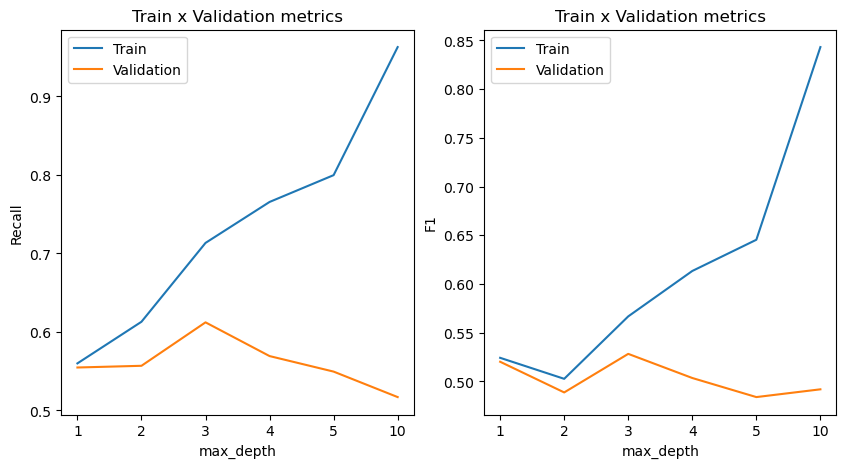

In [305]:
# Evaluating max_depth
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for max_depth in max_depth_list:
    dt = DecisionTreeClassifier(max_depth=max_depth,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the above plots, both recall and F1 scores are increasing in training and validation when max_depth approaches 3, before the difference between training and validation increases significantly.

Hence, max_depth=3 is optimal to use for the optimised model.

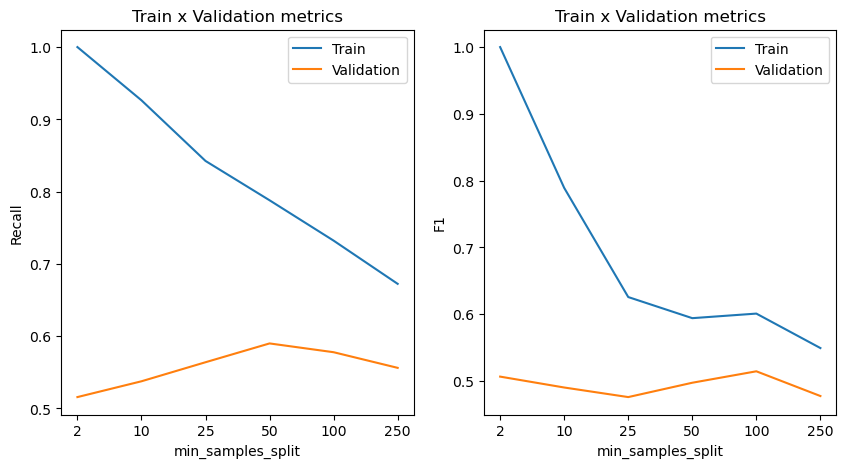

In [306]:
# Evaluating min_samples_split
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_split in min_samples_split_list:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

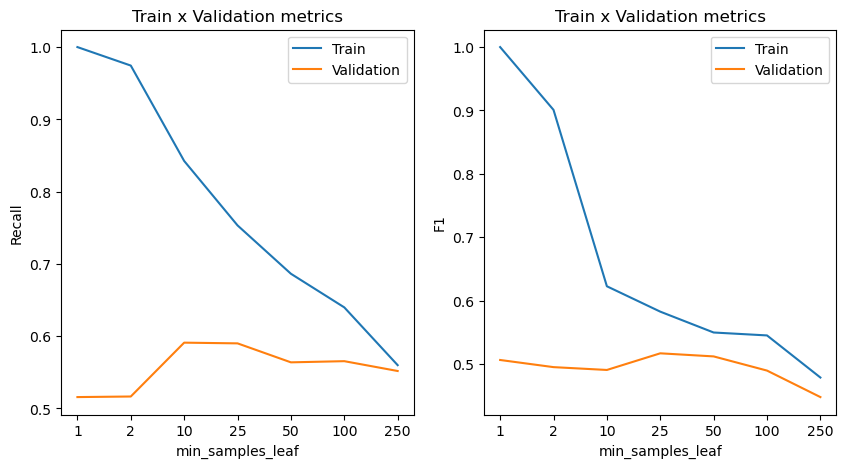

In [307]:
# Evaluating min_samples_leaf
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_leaf in min_samples_leaf_list:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the plot of metrics against min_samples_split and min_samples_leaf above, it is hard to determine which are the best values of hyperparameters to use. GridSearchCV will be used to inform us which hyperparameter values are optimal, based on the cross validation score.

### Using GridSearchCV to choose the best hyperparameter values

GridSearchCV tries all possible hyperparameter combinations within a predefined space, which is usually better than trial and error (as done above) that is prone to missing optimal configurations, especially if hyperparameters are tested in silos.

In [308]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {"max_depth" : [1, 2, 3, 4, 5, 10],
                "min_samples_split" : [2, 10, 25, 50, 100, 250],
                "min_samples_leaf" : [1, 2, 10, 25, 50, 100, 250],
                "criterion" : ["gini", "entropy"],
                "class_weight" : ["balanced"]
                }

# Initialise and run GridSearchCV
dt_baseline = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=dt_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv
                            )

# Build a grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameter values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Best hyperparameter values: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best mean cross-validated score: 0.5293644005206755


### Optimise the decision tree

The optimal decision tree will be built using the best hyperparameter values identified by GridSearchCV.

In [309]:
# Build the optimised decision tree model
dt_model = DecisionTreeClassifier(criterion="gini",
                                    max_depth=3,
                                    min_samples_split=2,
                                    min_samples_leaf=10,
                                    class_weight=CLASS_WEIGHT,
                                    random_state=RANDOM_STATE
                                    )

# Build the decision tree model on the training set
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=10, random_state=42)

In [310]:
# Compare recall and f1 scores in training and validation
pred_train = dt_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised decision tree model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised decision tree model
recall_train : 0.713362676840402
f1_train : 0.5666489324955579

recall_cv_mean : 0.6144293017850064
f1_cv_mean : 0.5293644005206755


In [311]:
# Predict X_test
y_pred = dt_model.predict(X_test)
y_pred

array([1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1,
       2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       1, 1, 2, 1, 0, 2, 2, 1, 1, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1,
       2, 2, 1, 1, 0, 1, 1], dtype=int64)

### Visualise the decision tree

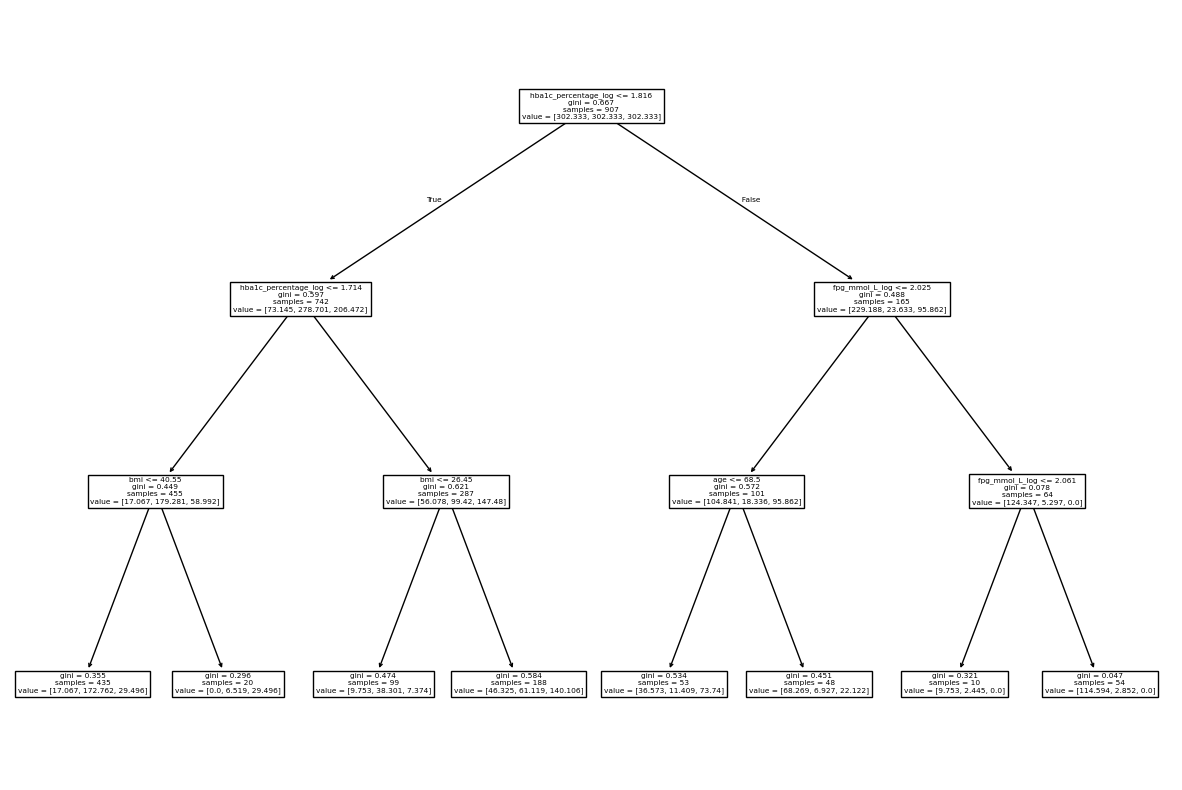

In [312]:
# Show the optimised decision tree model as a plot
from sklearn.tree import plot_tree

feature_cols = X.columns

plt.figure(figsize=(15,10))
plot_tree(dt_model.fit(X_train, y_train), feature_names=feature_cols)
plt.show()

In [313]:
# Show all class names
dt_model.classes_

array([0, 1, 2], dtype=int64)

### Confusion Matrix, Classfication Report and AUC_ROC

Evaluation of the optimised decision tree model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [314]:
# Generate confusion matrix and display with each row and column labelled
from sklearn.metrics import confusion_matrix

cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])
cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,14,2,15
Diabetes_no_actual,9,113,64
Diabetes_borderline_actual,4,1,5


The optimised decision tree model did not manage to correctly classify any borderline diabetes cases.

In [315]:
# Generate classification report
from sklearn.metrics import classification_report

dt_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised decision tree")
print(dt_model_classfication_report)

Classification report of optimised decision tree
                     precision    recall  f1-score   support

       Diabetes_yes       0.52      0.45      0.48        31
        Diabetes_no       0.97      0.61      0.75       186
Diabetes_borderline       0.06      0.50      0.11        10

           accuracy                           0.58       227
          macro avg       0.52      0.52      0.45       227
       weighted avg       0.87      0.58      0.68       227



In [316]:
from sklearn.metrics import roc_auc_score

y_pred_proba = dt_model.predict_proba(X_test)

dt_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(dt_model_roc_auc)

0.7595919170185778


### Feature Importance

In detecting Type 2 diabetes, it is important to identify which features contribute to the optimised model's prediction.
This will also be used in comparison to other classification techniques explored later.

Feature importance values (entropy) sorted in descending order
hba1c_percentage_log: 0.580435438582501
bmi: 0.19167920760225748
fpg_mmol_L_log: 0.15528969345467492
age: 0.07259566036056674
high_blood_pressure: 0.0
gender: 0.0
current_smoking_freq: 0.0
hdl_mmol_L_log: 0.0


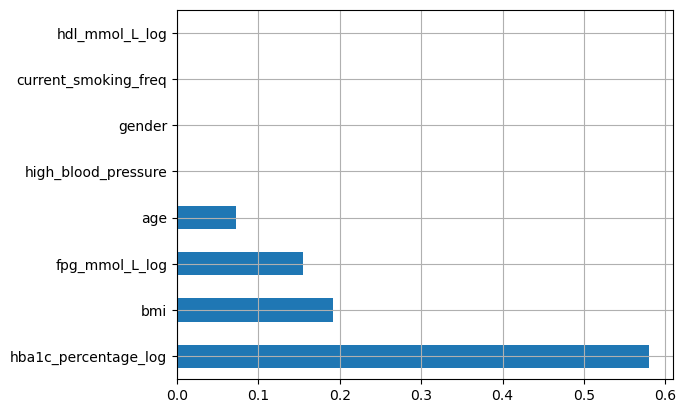

In [317]:
# Show the entropy importance of each feature
feature_importance = pd.Series(dt_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (entropy) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()

## Random Forest

Similar to building an optimised decision tree, different values of hyperparameters will be tested.

An additional hyperparameter is n_estimators, which specifies the number of decision trees that make up the random forest.

In [318]:
from sklearn.ensemble import RandomForestClassifier

In [319]:
# Create a list of values for the Random Forest Classifier parameters to observe their effects on model performance
max_depth_list = [1, 2, 3, 4, 5, 10]
min_samples_split_list = [2, 10, 25, 50, 100, 250]
min_samples_leaf_list = [1, 2, 10, 25, 50, 100, 250]
n_estimators_list = [10, 15, 25, 50, 75, 100]

CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

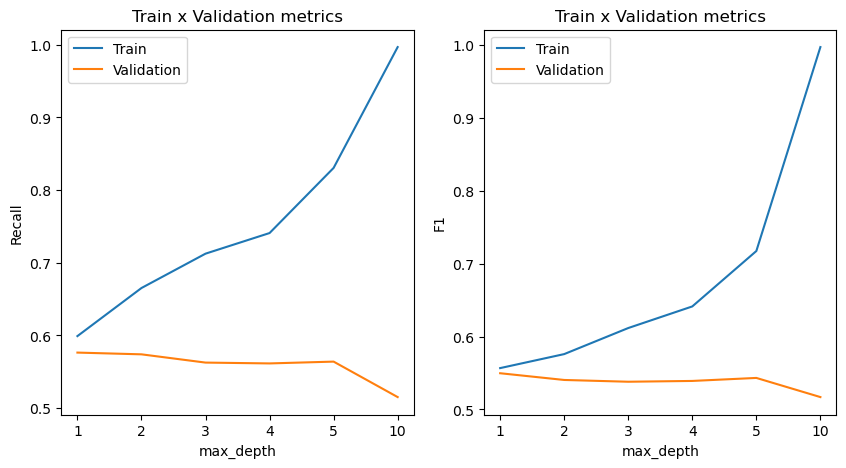

In [320]:
# Evaluating max_depth
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for max_depth in max_depth_list:
    rf = RandomForestClassifier(max_depth=max_depth,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

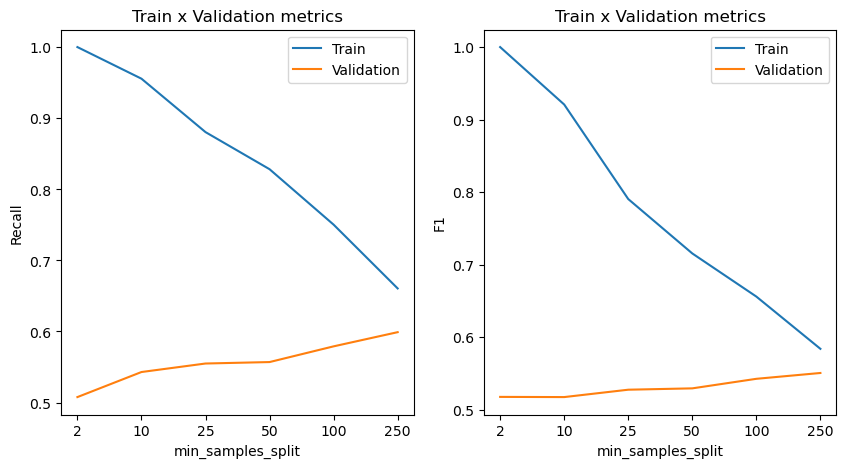

In [321]:
# Evaluating min_samples_split
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_split in min_samples_split_list:
    rf = RandomForestClassifier(min_samples_split=min_samples_split,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

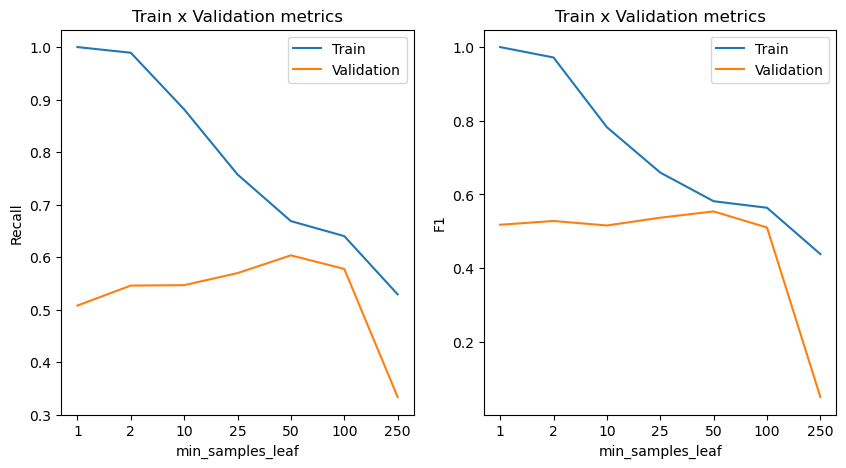

In [322]:
# Evaluating min_samples_leaf
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_leaf in min_samples_leaf_list:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

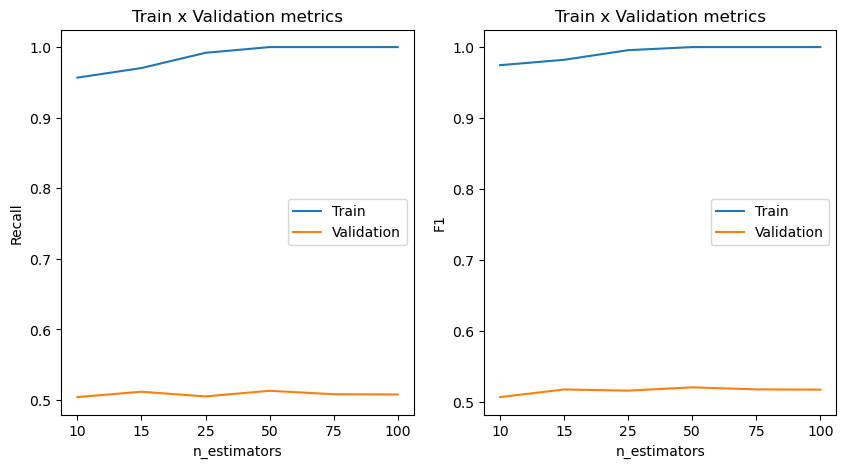

In [323]:
# Evaluating n_estimators
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("n_estimators")
plt.ylabel("F1")
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

In [324]:
# Define parameter grid
param_grid = {"max_depth" : [1, 2, 3, 4, 5, 10],
                "min_samples_split" : [2, 10, 25, 50, 100, 250],
                "min_samples_leaf" : [1, 2, 10, 25, 50, 100, 250],
                "n_estimators" : [10, 15, 25, 50, 75, 100],
                "criterion" : ["gini", "entropy"],
                "class_weight" : ["balanced"]
}

# Initialise and run GridSearchCV
rf_baseline = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=rf_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1
                            )

# Build the grid search on the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Best hyperparameters values: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 25}
Best mean cross-validated score: 0.5650612536711218


### Optimise the Random Forest model

The optimal random forest model will be built using the best hyperparameter values identified by GridSearchCV.

In [325]:
# Build the optimised random forest model
rf_model = RandomForestClassifier(criterion="gini",
                                    max_depth=5,
                                    min_samples_split=10,
                                    min_samples_leaf=1,
                                    n_estimators=25,
                                    class_weight=CLASS_WEIGHT,
                                    random_state=RANDOM_STATE
                                    )

# Build the random forest model on the training set
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=10, n_estimators=25, random_state=42)

In [326]:
# Compare recall and f1 scores in training and validation
pred_train = rf_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised random forest model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised random forest model
recall_train : 0.8003036851514502
f1_train : 0.697791515720238

recall_cv_mean : 0.5573941794143137
f1_cv_mean : 0.5340114364762747


In [327]:
# Predict X_test
y_pred = rf_model.predict(X_test)
y_pred

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 0,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1,
       1, 1, 1, 1, 2, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised random forest model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [328]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,24,5,2
Diabetes_no_actual,12,155,19
Diabetes_borderline_actual,3,4,3


In [329]:
# Import library to generate classification report
from sklearn.metrics import classification_report

rf_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised random forest")
print(rf_model_classfication_report)

Classification report of optimised random forest
                     precision    recall  f1-score   support

       Diabetes_yes       0.62      0.77      0.69        31
        Diabetes_no       0.95      0.83      0.89       186
Diabetes_borderline       0.12      0.30      0.18        10

           accuracy                           0.80       227
          macro avg       0.56      0.64      0.58       227
       weighted avg       0.86      0.80      0.83       227



In [330]:
from sklearn.metrics import roc_auc_score

y_pred_proba = rf_model.predict_proba(X_test)

rf_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(rf_model_roc_auc)

0.8039810993896642


### Feature Importance

Feature importance values (gini) sorted in descending order
hba1c_percentage_log: 0.36002762421701134
fpg_mmol_L_log: 0.258182660312599
hdl_mmol_L_log: 0.1191899029361479
age: 0.0980037880671139
bmi: 0.09701887082791964
high_blood_pressure: 0.03946197001533892
gender: 0.014152159231223115
current_smoking_freq: 0.013963024392646137


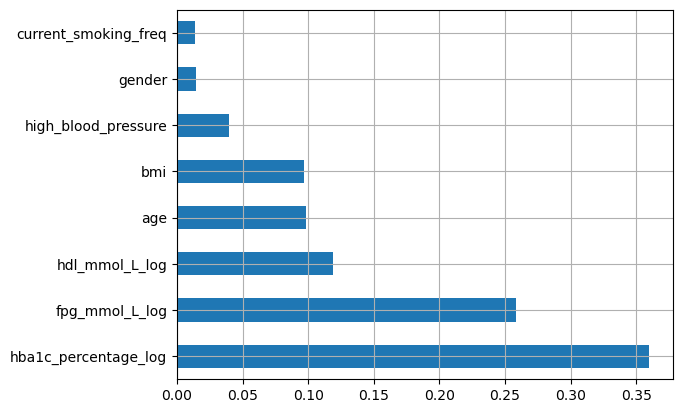

In [331]:
# Show the entropy importance of each feature
feature_importance = pd.Series(rf_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (gini) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()

## XGBoost

On top of the hyperparameters seen in the Random Forest Classifier, XGBoost has an additional hyperparameters learning_rate, which specifies the size of the step on gradient descent and prevent overfitting.

In [332]:
# Import library
from xgboost import XGBClassifier

In [333]:
# Define the parameter grid
param_grid = {"n_estimators" : [150, 250],
                "max_depth" : [3, 5],
                "learning_rate" : [0.05, 0.1],
                "reg_lambda" : [1, 5.0],
                "reg_alpha" : [0],
                "gamma" : [0.01, 0.1],
                "subsample": [0.80, 0.90],
                "colsample_bytree": [0.8, 1],
                "min_child_weight": [1,3]
}

# Initialise and run GridSearchCV
xgb_baseline = XGBClassifier(objective="multi:softmax",
                                num_class=3,
                                random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=xgb_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best hyperparameters values: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 250, 'reg_alpha': 0, 'reg_lambda': 5.0, 'subsample': 0.8}
Best mean cross-validated score: 0.530566994994327


### Optimise the XGBoost model

The optimal XGBoost model will be built using the best hyperparameter values identified by GridSearchCV.

In [334]:
xgb_model = XGBClassifier(objective="softmax",
                            num_class=3,
                            n_estimators=250,
                            max_depth=5,
                            learning_rate=0.05,
                            reg_lambda=5.0,
                            reg_alpha=0,
                            gamma=0.1,
                            subsample=0.8,
                            colsample_bytree=1,
                            min_child_weight=1,
                            random_state=RANDOM_STATE
                            )

# Fit the optimised XGBClassifier to the training set
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [335]:
# Compare recall and f1 scores in training and validation
pred_train = xgb_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised random forest model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised random forest model
recall_train : 0.872803566745345
f1_train : 0.9214357937310416

recall_cv_mean : 0.5198681097204587
f1_cv_mean : 0.530566994994327


In [336]:
# Make prediction on the test set
y_pred = xgb_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised XGBoost model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [337]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=xgb_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,21,10,0
Diabetes_no_actual,9,177,0
Diabetes_borderline_actual,3,7,0


In [338]:
# Import library to generate classification report
from sklearn.metrics import classification_report

xgb_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised XGBoost")
print(xgb_model_classfication_report)

Classification report of optimised XGBoost
                     precision    recall  f1-score   support

       Diabetes_yes       0.64      0.68      0.66        31
        Diabetes_no       0.91      0.95      0.93       186
Diabetes_borderline       0.00      0.00      0.00        10

           accuracy                           0.87       227
          macro avg       0.52      0.54      0.53       227
       weighted avg       0.83      0.87      0.85       227



c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [339]:
from sklearn.metrics import roc_auc_score

y_pred_proba = xgb_model.predict_proba(X_test)

xgb_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(xgb_model_roc_auc)

0.7961224668204548


### Feature Importance

Feature importance values (gain) sorted in descending order
hba1c_percentage_log: 0.3415846824645996
high_blood_pressure: 0.10904216021299362
fpg_mmol_L_log: 0.10093335807323456
gender: 0.1002669632434845
age: 0.09304942190647125
hdl_mmol_L_log: 0.08854536712169647
bmi: 0.08714297413825989
current_smoking_freq: 0.07943505048751831


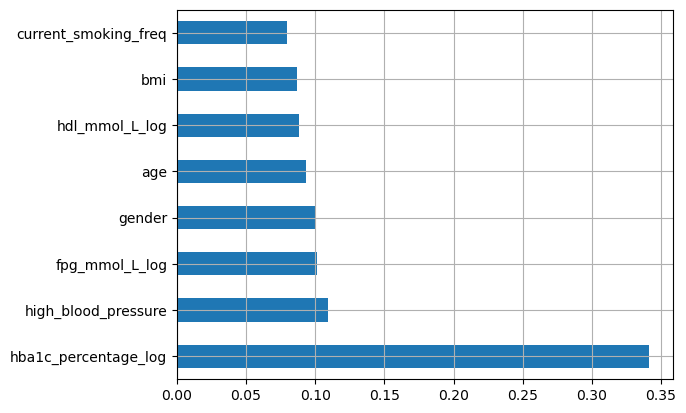

In [340]:
# Show the entropy importance of each feature
feature_importance = pd.Series(xgb_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (gain) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()

## AdaBoost

In [341]:
# Import library
from sklearn.ensemble import AdaBoostClassifier

In [342]:
# Define the parameter grid
param_grid = {"n_estimators" : [50, 100, 150],
                "learning_rate" : [0.01, 0.2, 0.3],
                "estimator__criterion": ["gini", "entropy"],
                "estimator__max_depth": [2, 3, 5],
                "estimator__min_samples_split": [5, 10, 25],
                "estimator__min_samples_leaf": [1, 5, 10],
}

# Initialise and run GridSearchCV
weak_learner = DecisionTreeClassifier(class_weight=CLASS_WEIGHT, random_state=RANDOM_STATE)
adb_baseline = AdaBoostClassifier(estimator=weak_learner,
                                    algorithm="SAMME",
                                    random_state=RANDOM_STATE,    
                                    )
grid_search = GridSearchCV(estimator=adb_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best hyperparameters values: {'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.2, 'n_estimators': 50}
Best mean cross-validated score: 0.5450219215503821


### Optimise the AdaBoost model

The optimal AdaBoost model will be built using the best hyperparameter values identified by GridSearchCV.

In [343]:
adb_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion="gini",
                                                            max_depth=2,
                                                            min_samples_split=5,
                                                            min_samples_leaf=1,
                                                            class_weight=CLASS_WEIGHT,
                                                            random_state=RANDOM_STATE                                                            
                                                            ),
                            n_estimators=50,
                            learning_rate=0.2,
                            algorithm="SAMME",
                            random_state=RANDOM_STATE
                            )

# Fit the optimised AdaBoostClassifier to the training set
adb_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=2,
                                                    min_samples_split=5,
                                                    random_state=42),
                   learning_rate=0.2, random_state=42)

In [344]:
# Compare recall and f1 scores in training and validation
pred_train = adb_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(adb_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(adb_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised random forest model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised random forest model
recall_train : 0.6279455727780476
f1_train : 0.5559920890327837

recall_cv_mean : 0.5726246111883696
f1_cv_mean : 0.5450219215503821


In [345]:
# Make prediction on the test set
y_pred = adb_model.predict(X_test)
y_pred

array([2, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 2, 1, 1, 2, 2, 0, 1, 0, 0, 2, 1,
       2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 1,
       2, 2, 1, 1, 2, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised AdaBoost model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [346]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=adb_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,19,2,10
Diabetes_no_actual,3,127,56
Diabetes_borderline_actual,2,2,6


In [347]:
# Import library to generate classification report
from sklearn.metrics import classification_report

adb_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised AdaBoost")
print(adb_model_classfication_report)

Classification report of optimised AdaBoost
                     precision    recall  f1-score   support

       Diabetes_yes       0.79      0.61      0.69        31
        Diabetes_no       0.97      0.68      0.80       186
Diabetes_borderline       0.08      0.60      0.15        10

           accuracy                           0.67       227
          macro avg       0.61      0.63      0.55       227
       weighted avg       0.91      0.67      0.76       227



In [348]:
from sklearn.metrics import roc_auc_score

y_pred_proba = adb_model.predict_proba(X_test)

adb_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(adb_model_roc_auc)

0.8182438435641762


### Feature Importance

Feature importance values (gain) sorted in descending order
hba1c_percentage_log: 0.7207854390293444
fpg_mmol_L_log: 0.23109289807690905
bmi: 0.04812166289374657
high_blood_pressure: 0.0
gender: 0.0
age: 0.0
current_smoking_freq: 0.0
hdl_mmol_L_log: 0.0


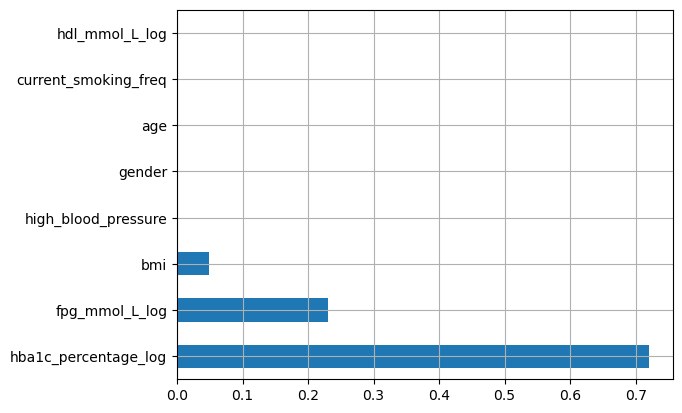

In [349]:
# Show the entropy importance of each feature
feature_importance = pd.Series(adb_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (gain) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()

## Feature Scaling

The remaining methods to be explored are more sensitive to the scale of the feature values. Hence, feature scaling will be introduced.

A pipeline is needed to prevent data leakage. make_pipeline will be used to create a sequential workflow that chains multiple steps together:
1. StandardScaler fits on the training fold of the StratifiedKFold and transforms it
2. The same scaler fitted on the training fold transforms the validation fold of the StratifiedKFold
3. The model trains on the scaled training data
4. The model predicts on the scaled validation data

Since the validation fold does not influence the scaling parameters, no data is leaked.

In [350]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Logistic Regression

In [351]:
# Import library
from sklearn.linear_model import LogisticRegression

In [352]:
# Initialise the pipeline with StandardScaler and Logistic Regression

pipe = make_pipeline(StandardScaler(),
                    LogisticRegression(class_weight=CLASS_WEIGHT,
                                        random_state=RANDOM_STATE,
                                        multi_class="multinomial",
                                        n_jobs=-1
                                        )
                    )

In [353]:
# Define the parameter grid
param_grid = {"logisticregression__penalty" : ["l2", "l1", "elasticnet"],
                "logisticregression__solver" : ["lbfgs", "newton-cholesky", "saga"],
                "logisticregression__max_iter": [100, 200]
}

# Initialise and run GridSearchCV
grid_search = GridSearchCV(estimator=pipe,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters values: {'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Best mean cross-validated score: 0.5192818135035855


c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit

### Optimise the Logistic Regression model

The optimal Logistic Regression model will be built using the best hyperparameter values identified by GridSearchCV.

In [354]:
lgr_optimised = LogisticRegression(penalty="l2",
                                solver="lbfgs",
                                max_iter=50,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE,
                                multi_class="multinomial",
                                n_jobs=-1
                                    )

# Create pipeline with the optimised Logistic Regression hyperparameter values
lgr_model = make_pipeline(StandardScaler(), lgr_optimised)

# Fit the optimised Logistic Regression model to the training set
lgr_model.fit(X_train, y_train)

c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=50,
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=42))])

In [355]:
lgr_optimised_cv = LogisticRegression(penalty="l2",
                                solver="lbfgs",
                                max_iter=50,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE,
                                multi_class="multinomial",
                                n_jobs=-1
                                        )

# Create a pipeline for cross validation
lgr_model_cv = make_pipeline(StandardScaler(), lgr_optimised_cv)

# Retrieve recall and f1 score for training
pred_train = lgr_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

# Retreive recall and f1 score for cross validation
recall_cv = cross_val_score(lgr_model_cv, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(lgr_model_cv, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised logistic regression model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ryans\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

Comparison of recall and f1 scores in the training and validation of the optimised logistic regression model
recall_train : 0.6318213403853888
f1_train : 0.5440751131855726

recall_cv_mean : 0.5590507218628025
f1_cv_mean : 0.510728884231181


In [356]:
# Make prediction on the test set
y_pred = lgr_model.predict(X_test)
y_pred

array([1, 0, 2, 1, 1, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2,
       1, 1, 2, 2, 0, 2, 2, 1, 1, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised Logistic Regression model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [357]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=lgr_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,22,4,5
Diabetes_no_actual,9,123,54
Diabetes_borderline_actual,2,3,5


In [358]:
# Import library to generate classification report
from sklearn.metrics import classification_report

lgr_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised Logistic Regression")
print(lgr_model_classfication_report)

Classification report of optimised Logistic Regression
                     precision    recall  f1-score   support

       Diabetes_yes       0.67      0.71      0.69        31
        Diabetes_no       0.95      0.66      0.78       186
Diabetes_borderline       0.08      0.50      0.14        10

           accuracy                           0.66       227
          macro avg       0.56      0.62      0.53       227
       weighted avg       0.87      0.66      0.74       227



In [359]:
from sklearn.metrics import roc_auc_score

y_pred_proba = lgr_model.predict_proba(X_test)

lgr_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(lgr_model_roc_auc)

0.817048461136356


### Feature Importance

In [360]:
# Extracting the logistic regression model
lgr = lgr_model.named_steps["logisticregression"]

# Using the coefficients of the features to determine their importance
feature_names = X_train.columns
coefficients = lgr.coef_

class_names = ["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"]
for i, class_name in enumerate(class_names):
    print(f"\n{class_name} feature importances")
    coef_df = pd.DataFrame({"feature": feature_names,
                            "coefficient": coefficients[i],
                            "abs_coefficient": abs(coefficients[i])
                            }).sort_values("abs_coefficient", ascending=False)
    print(coef_df)


Diabetes_yes feature importances
                feature  coefficient  abs_coefficient
5  hba1c_percentage_log     0.859285         0.859285
6        fpg_mmol_L_log     0.282205         0.282205
2                gender    -0.149662         0.149662
1   high_blood_pressure     0.144726         0.144726
3                   age     0.073771         0.073771
7        hdl_mmol_L_log    -0.054930         0.054930
0                   bmi     0.032234         0.032234
4  current_smoking_freq    -0.014767         0.014767

Diabetes_no feature importances
                feature  coefficient  abs_coefficient
5  hba1c_percentage_log    -0.872133         0.872133
1   high_blood_pressure    -0.225633         0.225633
0                   bmi    -0.210166         0.210166
6        fpg_mmol_L_log    -0.145999         0.145999
3                   age    -0.121899         0.121899
2                gender    -0.071660         0.071660
7        hdl_mmol_L_log     0.053286         0.053286
4  current_smok

## k-Nearest Neighbours

In [361]:
# Import library
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Initialise the pipeline with StandardScaler and KNeighborsClassifier

pipe = make_pipeline(StandardScaler(),
                    KNeighborsClassifier(algorithm="auto",
                                        metric="minkowski",
                                        n_jobs=-1
                                        )
                    )

In [363]:
# Define the parameter grid
param_grid = {"kneighborsclassifier__n_neighbors" : [3, 5, 7, 9],
                "kneighborsclassifier__weights" : ["uniform", "distance"],
                "kneighborsclassifier__p": [1, 2]
}

# Initialise and run GridSearchCV
grid_search = GridSearchCV(estimator=pipe,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters values: {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}
Best mean cross-validated score: 0.5084652524858677


### Optimise the k-Nearest Neighbors model

The optimal k-Nearest Neighbors model will be built using the best hyperparameter values identified by GridSearchCV.

In [ ]:
knn_optimised = KNeighborsClassifier(n_neighbors=5,
                                    weights="distance",
                                    p=1,
                                    algorithm="auto",
                                    metric="minkowski",
                                    n_jobs=-1
                                    )

# Create pipeline with the optimised kNN hyperparameter values
knn_model = make_pipeline(StandardScaler(), knn_optimised)

# Fit the optimised kNN model to the training set
knn_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_jobs=-1, p=1, weights='distance'))])

In [365]:
knn_optimised_cv = KNeighborsClassifier(n_neighbors=5,
                                        weights="distance",
                                        p=1,
                                        algorithm="auto",
                                        metric="minkowski",
                                        n_jobs=-1
                                        )

# Create a pipeline for cross validation
knn_model_cv = make_pipeline(StandardScaler(), knn_optimised_cv)

# Retrieve recall and f1 score for training
pred_train = knn_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

# Retreive recall and f1 score for cross validation
recall_cv = cross_val_score(knn_model_cv, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(knn_model_cv, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised k-nearest neighbors model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised k-nearest neighbors model
recall_train : 1.0
f1_train : 1.0

recall_cv_mean : 0.4877779188584558
f1_cv_mean : 0.5084652524858677


In [366]:
# Make prediction on the test set
y_pred = knn_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised Logistic Regression model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [367]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=knn_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,13,15,3
Diabetes_no_actual,6,177,3
Diabetes_borderline_actual,2,8,0


In [368]:
# Import library to generate classification report
from sklearn.metrics import classification_report

knn_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised Logistic Regression")
print(knn_model_classfication_report)

Classification report of optimised Logistic Regression
                     precision    recall  f1-score   support

       Diabetes_yes       0.62      0.42      0.50        31
        Diabetes_no       0.89      0.95      0.92       186
Diabetes_borderline       0.00      0.00      0.00        10

           accuracy                           0.84       227
          macro avg       0.50      0.46      0.47       227
       weighted avg       0.81      0.84      0.82       227



In [369]:
from sklearn.metrics import roc_auc_score

y_pred_proba = knn_model.predict_proba(X_test)

knn_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(knn_model_roc_auc)

0.7459170292822086


### Feature Importance

k-Nearest Neighbors is a supervised learning classification algorithm that uses k data points in its proximity to perform "majority voting" to predict the class of the individual point.

## Support Vector Machine

SVC is used as medical data often have non-linear relationships, which SVC can capture better compared to LinearSVC.

In [370]:
# Import library
from sklearn.svm import SVC

In [380]:
# Initialise the pipeline with StandardScaler and SVC

pipe = make_pipeline(StandardScaler(),
                    SVC(probability=True,
                        class_weight="balanced",
                        decision_function_shape="ovr",
                        random_state=RANDOM_STATE
                        )
                    )

In [382]:
# Define the parameter grid
param_grid = {"svc__C" : [0.01, 0.1, 0.5, 1.0],
                "svc__kernel" : ["linear", "poly", "rbf", "sigmoid"],
                "svc__degree" : [2, 3, 4],
                "svc__gamma" : ["scale", "auto", 0.01, 0.1, 0.5]
            }

# Initialise and run GridSearchCV
grid_search = GridSearchCV(estimator=pipe,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best hyperparameters values: {'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}
Best mean cross-validated score: 0.5252639154346778


### Optimise the k-Nearest Neighbors model

The optimal k-Nearest Neighbors model will be built using the best hyperparameter values identified by GridSearchCV.

In [383]:
svc_optimised = SVC(C=0.1,
                    kernel="poly",
                    degree=3,
                    gamma=0.1,
                    probability=True,
                    class_weight="balanced",
                    decision_function_shape="ovr",
                    random_state=RANDOM_STATE
                    )

# Create pipeline with the optimised kNN hyperparameter values
svc_model = make_pipeline(StandardScaler(), svc_optimised)

# Fit the optimised SVC model to the training set
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, class_weight='balanced', gamma=0.1, kernel='poly',
                     probability=True, random_state=42))])

In [384]:
svc_optimised_cv = SVC(C=0.1,
                    kernel="poly",
                    degree=3,
                    gamma=0.1,
                    probability=True,
                    class_weight="balanced",
                    decision_function_shape="ovr",
                    random_state=RANDOM_STATE
                    )

# Create a pipeline for cross validation
svc_model_cv = make_pipeline(StandardScaler(), svc_optimised_cv)

# Retrieve recall and f1 score for training
pred_train = svc_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

# Retreive recall and f1 score for cross validation
recall_cv = cross_val_score(svc_model_cv, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(svc_model_cv, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised SVC model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised SVC model
recall_train : 0.6316992230438782
f1_train : 0.5863511284828472

recall_cv_mean : 0.5241307750703724
f1_cv_mean : 0.5252639154346778


In [385]:
# Make prediction on the test set
y_pred = svc_model.predict(X_test)
y_pred

array([1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised Logistic Regression model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [386]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=svc_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,12,6,13
Diabetes_no_actual,2,163,21
Diabetes_borderline_actual,2,5,3


In [387]:
# Import library to generate classification report
from sklearn.metrics import classification_report

svc_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised Logistic Regression")
print(svc_model_classfication_report)

Classification report of optimised Logistic Regression
                     precision    recall  f1-score   support

       Diabetes_yes       0.75      0.39      0.51        31
        Diabetes_no       0.94      0.88      0.91       186
Diabetes_borderline       0.08      0.30      0.13        10

           accuracy                           0.78       227
          macro avg       0.59      0.52      0.51       227
       weighted avg       0.87      0.78      0.82       227



In [388]:
from sklearn.metrics import roc_auc_score

y_pred_proba = svc_model.predict_proba(X_test)

svc_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(svc_model_roc_auc)

0.7976361748475944


### Feature Importance

SVM

## Neural Network

In [ ]:
# Import libraries
from tensorflow.keras.model import Sequential
